## Exercise 1:  Wide and Deep Networks

- Try changing your assumptions about which features should be considered by the "non-linear" (deep) part of the network.  Can you get any improvements?
- Try using a different activation function in your wide and deep network. Do you get any improvements here?

In [1]:
import tensorflow as tf

2024-04-07 13:34:48.437784: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 13:34:49.502493: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-07 13:34:52.174401: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 13:34:55.470153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)
X_new = X_test[:3]

In [3]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

input_wide = tf.keras.layers.Input(shape=[5]) # features 0 to 4 
input_deep = tf.keras.layers.Input(shape=[4]) # features 4 to 7 
norm_layer_wide = tf.keras.layers.Normalization() 
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)

# Note, the following is just a shorthand where we construct and then attach the network all in one go
hidden1 = tf.keras.layers.Dense(30, activation="leaky_relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="leaky_relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), 
              loss_weights = (0.9, 0.1), 
              optimizer=optimizer, 
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

# Note the offsets are used here to split up the features according to our input layer
X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 4:] 
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 4:] 
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 4:] 
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]


norm_layer_wide.adapt(X_train_wide) 
norm_layer_deep.adapt(X_train_deep)

history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20, validation_data=((X_valid_wide, X_valid_deep), y_valid)) 
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - dense_2_RootMeanSquaredError: 1.8080 - loss: 3.0896 - val_dense_2_RootMeanSquaredError: 1.4690 - val_loss: 1.9415
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dense_2_RootMeanSquaredError: 0.8932 - loss: 0.7192 - val_dense_2_RootMeanSquaredError: 1.4113 - val_loss: 1.7917
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - dense_2_RootMeanSquaredError: 0.7515 - loss: 0.5084 - val_dense_2_RootMeanSquaredError: 1.6239 - val_loss: 2.3723
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_2_RootMeanSquaredError: 0.7004 - loss: 0.4417 - val_dense_2_RootMeanSquaredError: 1.3284 - val_loss: 1.5876
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_2_RootMeanSquaredError: 0.6776 - loss: 0.4133 - val_dense_2_RootMeanSquaredError: 1.3645 - val_loss: 1.6749
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - dense_2_RootMeanSquaredError: 0.6674 - loss: 0.4011 - val_dense_2_RootMeanSquaredError: 1.3404 - val_loss: 1.6162
Epo

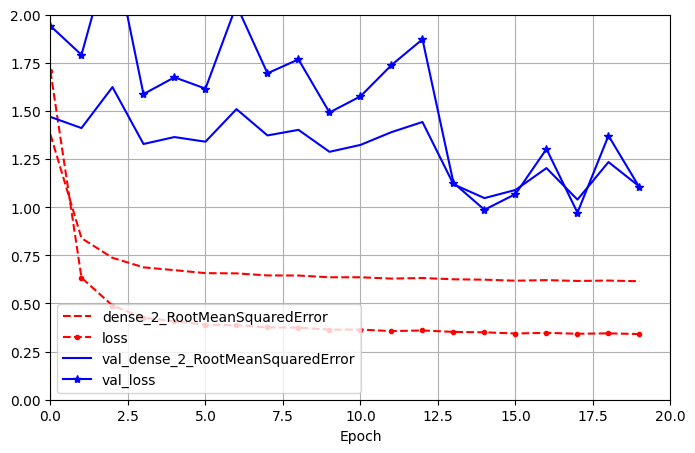

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 2], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()

## Exercise 2: Modifying the Wide and Deep Network

1. Modify the constructor of the wide and deep network to take parameters that govern the number of hidden layers and their width.  Now try running the new network with different properties for your hidden layers.  Can you improve your performance?

2. Modify the network class to use BatchNormalization, but add normalization after the activation function.  Examine your performance.

3. Modify the preceding class to use BatchNormalization before the activation function.  Examine your performance. 

In [31]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, layers = 5, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation(activation)
        self.hidden_layers = []
        for i in range(layers):
            self.hidden_layers.append(tf.keras.layers.Dense(units))
        #self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)

    def connections(self, layer):
        h = self.hidden_layers(layer)
        n = self.batch_norm(h)
        a = self.activation(n)
        return a

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.batch_norm(input_wide)
        norm_deep = self.batch_norm(input_deep)
        last = norm_deep
        for l in self.hidden_layers:
            last = l.connections(last)
        concat = tf.keras.layers.concatenate([norm_wide, last])
        output = self.main_output(concat)
        aux_output = self.aux_output(last)
        return output, aux_output

tf.random.set_seed(42)  # extra code – just for reproducibility
model = WideAndDeepModel(30, layers = 5, activation="relu", name="my_cool_model")

In [32]:
model.summary()

Model: "my_cool_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_11          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
#tf.keras.backend.clear_session()
#tf.random.set_seed(42)  # extra code – just for reproducibility
#model = WideAndDeepModel(30, activation="relu", name="my_cool_model")
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError", "RootMeanSquaredError"])
#model.batch_norm.adapt(X_train_wide)
#model.batch_norm.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
print(eval_results)
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/layer.py:1248: UserWarning: Layer 'my_cool_model' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Input 0 of layer "batch_normalization_11" is incompatible with the layer: expected axis -1 of input shape to have value 5, but received input with shape (None, 4)''
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/layer.py:357: UserWarning: 

ValueError: Exception encountered when calling WideAndDeepModel.call().

[1mInput 0 of layer "batch_normalization_11" is incompatible with the layer: expected axis -1 of input shape to have value 5, but received input with shape (None, 4)[0m

Arguments received by WideAndDeepModel.call():
  • inputs=('tf.Tensor(shape=(None, 5), dtype=float32)', 'tf.Tensor(shape=(None, 4), dtype=float32)')

## Exercise 3: Comparing SELU and ReLU

Let's examine the performance of SELU and ReLU in the context of a deep network with 100 layers.  I've set up the example below to use SELU and Lecun Normalization.  Examine the performance, and then contrast using ReLU and He normalization.

In [49]:
import tensorflow as tf
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

# 100 hidden layers
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Get the data and train the network:

In [50]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

# Remember to scale the inputs!
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


2024-04-04 16:00:26.057064: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1714/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3014 - loss: 1.8515

2024-04-04 16:00:44.002016: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15680000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.3018 - loss: 1.8503 - val_accuracy: 0.6292 - val_loss: 1.0144
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.6528 - loss: 0.9145 - val_accuracy: 0.7160 - val_loss: 0.7831
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7288 - loss: 0.7303 - val_accuracy: 0.7686 - val_loss: 0.6882
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7875 - loss: 0.5990 - val_accuracy: 0.7694 - val_loss: 0.6786
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8173 - loss: 0.5328 - val_accuracy: 0.8124 - val_loss: 0.5330


In [52]:
relu_model = tf.keras.Sequential()
relu_model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

# 100 hidden layers
for layer in range(100):
    relu_model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
relu_model.add(tf.keras.layers.Dense(10, activation="softmax"))

relu_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

# Remember to scale the inputs!
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history = relu_model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


2024-04-04 16:03:49.151926: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1717/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1528 - loss: 2.2033

2024-04-04 16:04:06.955819: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15680000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.1529 - loss: 2.2030 - val_accuracy: 0.3242 - val_loss: 1.7041
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3423 - loss: 1.6512 - val_accuracy: 0.5684 - val_loss: 1.0546
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.4594 - loss: 1.3047 - val_accuracy: 0.5480 - val_loss: 1.1513
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5149 - loss: 1.2082 - val_accuracy: 0.4372 - val_loss: 1.2484
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4989 - loss: 1.1591 - val_accuracy: 0.6538 - val_loss: 0.9055
